#Anomaly detection in financial data

##Objectives:

Showcase few techniques as building blocks for a comprehensive anomaly detection and alerting system with SAS AML integration

##About Data 

Synthetic dataset of mobile money transactions

### Approach for detecting abnormal values includes following:
- Simple Data visualization
- Statistical methods (IQR range, Percentiles, Mean and Standard Deviation, Median Absolute Deviation)
- model-based methods (to be added)

##### Load required libraries

In [0]:
import pandas as pd 
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
#%pylab inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

from pyspark.sql.functions import *

from pyspark.sql.types import *

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score, pairwise_distances

from sklearn.cluster import DBSCAN

##### Looking at the raw data

In [0]:
raw_df = spark.sql("""SELECT cash.time_key AS step,
       cash.transaction_type_key      AS type,
       cash.currency_amount           AS amount,
       cash.account_key               AS nameOrig,
FROM   fsc_cash_flow_fact cash""")

In [0]:
raw_df = spark.sql("select * from aml.sample_data_new")

raw_df.display()

step,type,amount,nameOrig
1,CASH_OUT,181.0,C840083671
1,CASH_OUT,229133.9375,C905080434
1,CASH_OUT,110414.7109375,C768216420
1,CASH_OUT,56953.8984375,C1570470538
1,CASH_OUT,5346.89013671875,C512549200
1,CASH_OUT,23261.30078125,C2072313080
1,CASH_OUT,82940.3125,C1528834618
1,CASH_OUT,47458.859375,C527211736
1,CASH_OUT,136872.921875,C1533123860
1,CASH_OUT,94253.328125,C1718906711


##### Data overview
- Each step represents an hour of simulation
- For the purpose of this notebook we will be focusing on type, name Orig and amount 
- This data is limited to two weeks and we will create two time periods week 1 and week 2
- Basis this we will calculate a ratio of amounts between week 1 to week 2 for all type of transactions
- We will primarily use this ratio for anomaly detection. In real-world scenario there will be multiple factors taken into in consideration, however for this sample data we will focus on the ratio

In [0]:
raw_df1 = raw_df.withColumn("step",col("step").cast("int")).withColumn("amount",col("amount").cast("float"))

raw_df1.display(5)

step,type,amount,nameOrig
1,CASH_OUT,181.0,C840083671
1,CASH_OUT,229133.94,C905080434
1,CASH_OUT,110414.71,C768216420
1,CASH_OUT,56953.9,C1570470538
1,CASH_OUT,5346.89,C512549200
1,CASH_OUT,23261.3,C2072313080
1,CASH_OUT,82940.31,C1528834618
1,CASH_OUT,47458.86,C527211736
1,CASH_OUT,136872.92,C1533123860
1,CASH_OUT,94253.33,C1718906711


In [0]:
## Creating week flag for two time periods

raw_df2=raw_df1.withColumn("week_flg",
when((raw_df1["step"]>=1) & (raw_df1["step"]<=168) , "week_1")
.otherwise("week_2"))

raw_df2.display(5)

step,type,amount,nameOrig,week_flg
1,CASH_OUT,181.0,C840083671,week_1
1,CASH_OUT,229133.94,C905080434,week_1
1,CASH_OUT,110414.71,C768216420,week_1
1,CASH_OUT,56953.9,C1570470538,week_1
1,CASH_OUT,5346.89,C512549200,week_1
1,CASH_OUT,23261.3,C2072313080,week_1
1,CASH_OUT,82940.31,C1528834618,week_1
1,CASH_OUT,47458.86,C527211736,week_1
1,CASH_OUT,136872.92,C1533123860,week_1
1,CASH_OUT,94253.33,C1718906711,week_1


In [0]:
## Data aggregation 
agg_df = raw_df2.groupBy("nameOrig","week_flg","type").agg(
  sum("amount").alias("amt"))

agg_df.display(5)

nameOrig,week_flg,type,amt
C1645624121,week_1,CASH_IN,7965.490234375
C1061448687,week_1,CASH_IN,371883.8125
C478209179,week_1,CASH_IN,270824.40625
C609887969,week_1,CASH_OUT,161796.953125
C137123763,week_1,CASH_IN,68988.2109375
C16736375,week_1,CASH_IN,336237.375
C646445398,week_1,CASH_IN,36860.9609375
C159860059,week_1,CASH_IN,231460.09375
C478123697,week_1,CASH_IN,198303.640625
C1240727361,week_1,CASH_IN,348792.34375


In [0]:
## Transposing time period flags

agg_df1 = agg_df.groupBy("nameOrig","type").pivot("week_flg").agg(expr("coalesce(first(amt), \"0\")"))

agg_df1.display(5)

nameOrig,type,week_1,week_2
C323996728,CASH_IN,129504.609375,0
C2036107171,CASH_IN,58257.171875,0
C1757487266,CASH_IN,252762.796875,0
C1730005507,CASH_OUT,189121.875,0
C646166723,CASH_OUT,502661.875,124215.8515625
C180064137,CASH_OUT,109786.2890625,0
C2085107288,CASH_OUT,167420.9375,0
C1668802798,CASH_IN,3015.419921875,0
C348708207,CASH_OUT,180741.140625,0
C1929308950,CASH_OUT,24010.44921875,0


In [0]:
## Keeping records where both weeks had some amount
agg_df2 = agg_df1.filter((col("week_2") > 0 ) & (col("week_1") > 0))

agg_df2.display(5)

nameOrig,type,week_1,week_2
C646166723,CASH_OUT,502661.875,124215.8515625
C546758137,CASH_OUT,252175.15625,51241.87109375
C2101503246,CASH_OUT,91854.296875,127347.3515625
C782079880,CASH_OUT,37969.05078125,110608.34375
C1371767815,CASH_IN,53181.6015625,61631.76953125
C1294787688,CASH_OUT,609418.4375,173564.953125
C584702898,CASH_OUT,157874.078125,58734.01953125
C1345588509,CASH_OUT,33604.71875,136455.9375
C1504006441,CASH_OUT,14677.490234375,24888.220703125
C662962247,CASH_IN,281007.84375,230496.265625


In [0]:
agg_df2.count()

Out[35]: 422

##### Creating ratio of week 2 amount and week 1 amount

In [0]:
agg_df3 = agg_df2.withColumn("raw_ratio", col("week_2") / col("week_1"))

agg_df4 =agg_df3.select("nameOrig","type", "week_1", "week_2",round('raw_ratio',2).alias('ratio')) 

agg_df4.display(5)

nameOrig,type,week_1,week_2,ratio
C646166723,CASH_OUT,502661.875,124215.8515625,0.25
C546758137,CASH_OUT,252175.15625,51241.87109375,0.2
C2101503246,CASH_OUT,91854.296875,127347.3515625,1.39
C782079880,CASH_OUT,37969.05078125,110608.34375,2.91
C1371767815,CASH_IN,53181.6015625,61631.76953125,1.16
C1294787688,CASH_OUT,609418.4375,173564.953125,0.28
C584702898,CASH_OUT,157874.078125,58734.01953125,0.37
C1345588509,CASH_OUT,33604.71875,136455.9375,4.06
C1504006441,CASH_OUT,14677.490234375,24888.220703125,1.7
C662962247,CASH_IN,281007.84375,230496.265625,0.82


#### Data Visualization for identifying customers with abnormal ratios

Out[38]:

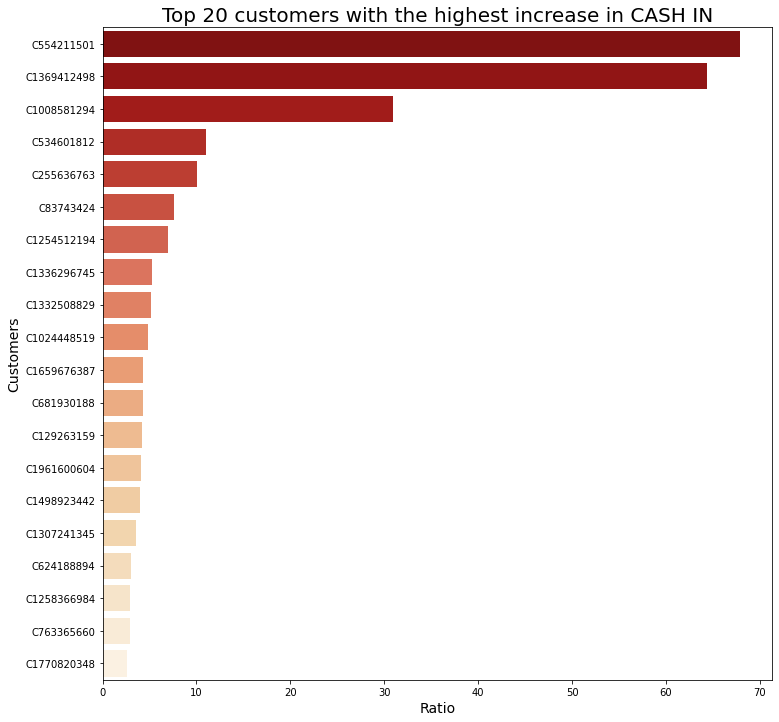

Text(0.5, 1.0, 'Top 20 customers with the highest increase in CASH IN')

In [0]:
agg_sort_cash_in = agg_df4.filter(col("type") == 'CASH_IN').sort(desc("ratio"))

plt.figure(figsize=(12,12))
bar = sns.barplot(x='ratio',y='nameOrig',data = agg_sort_cash_in.limit(20).toPandas() 
                  ,palette='OrRd_r')
plt.ylabel("Customers",fontsize = 14)
plt.xlabel("Ratio", fontsize = 14)
plt.title('Top 20 customers with the highest increase in CASH IN',fontsize=20)

Out[40]:

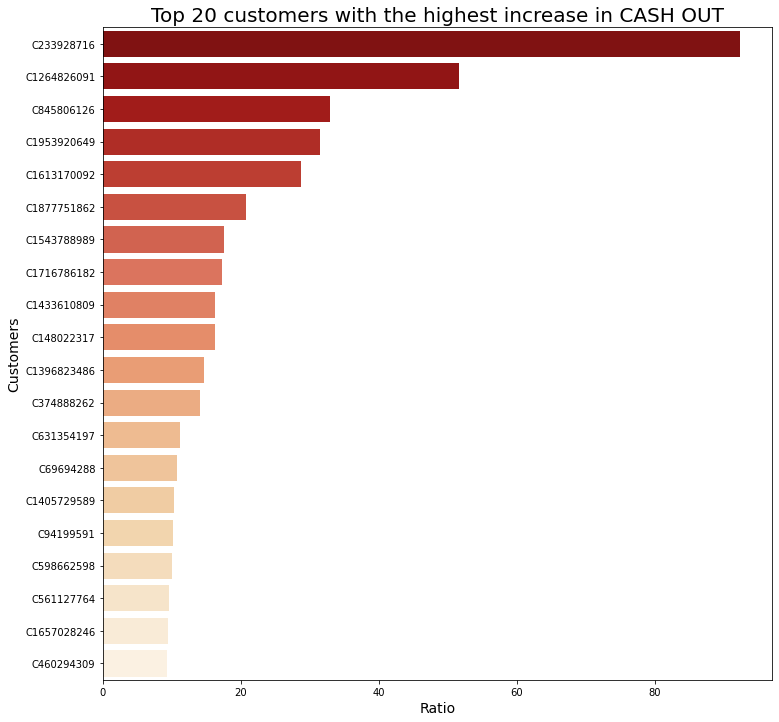

Text(0.5, 1.0, 'Top 20 customers with the highest increase in CASH OUT')

In [0]:
agg_sort_cash_out = agg_df4.filter(col("type") == 'CASH_OUT').sort(desc("ratio"))

plt.figure(figsize=(12,12))
bar = sns.barplot(x='ratio',y='nameOrig',data = agg_sort_cash_out.limit(20).toPandas() 
                  ,palette='OrRd_r')
plt.ylabel("Customers",fontsize = 14)
plt.xlabel("Ratio", fontsize = 14)
plt.title('Top 20 customers with the highest increase in CASH OUT',fontsize=20)

Out[41]:

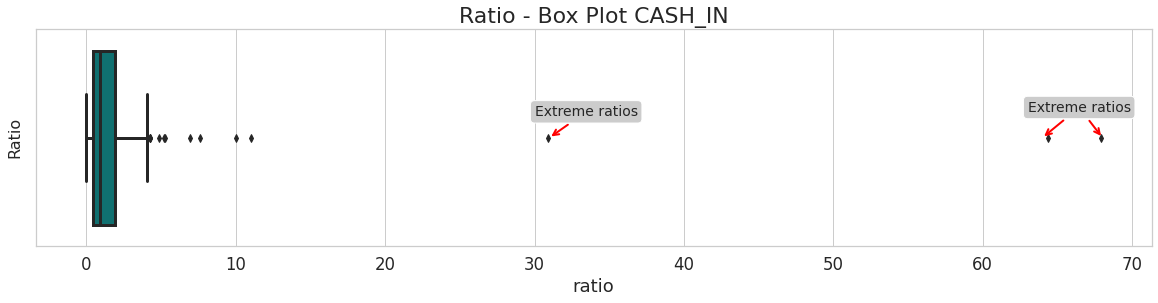

Text(30, -0.1, 'Extreme ratios')

In [0]:
sns.set(rc={'figure.figsize':(20, 4)})
sns.set(font_scale=1.5) 
sns.set_style("whitegrid")
ts = sns.boxplot(data = agg_df4.filter(col("type")=='CASH_IN').toPandas(), x = 'ratio', linewidth = 3, color = 'teal')
plt.title('Ratio - Box Plot CASH_IN', size = 22)
ts.set_ylabel('Ratio', fontsize=16)

ts.annotate('Extreme ratios', xy=(68,0), xytext=(63,-0.12), fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='red', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

ts.annotate('Extreme ratios', xy=(64,0), xytext=(63,-0.12), fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='red', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

ts.annotate('Extreme ratios', xy=(31,0), xytext=(30,-0.10), fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='red', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

Out[44]:

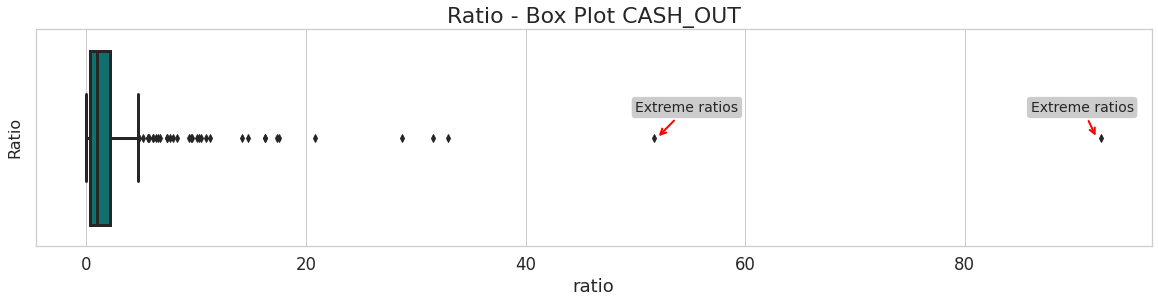

Text(50, -0.12, 'Extreme ratios')

In [0]:
sns.set(rc={'figure.figsize':(20, 4)})
sns.set(font_scale=1.5) 
sns.set_style("whitegrid")
ts = sns.boxplot(data = agg_df4.filter(col("type")=='CASH_OUT').toPandas(), x = 'ratio', linewidth = 3, color = 'teal')
plt.title('Ratio - Box Plot CASH_OUT', size = 22)
ts.set_ylabel('Ratio', fontsize=16)

ts.annotate('Extreme ratios', xy=(92,0), xytext=(86,-0.12), fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='red', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

ts.annotate('Extreme ratios', xy=(52,0), xytext=(50,-0.12), fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='red', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

#### Detect Anomalies - statistical approach

##### Interquartile range

49 outliers are found

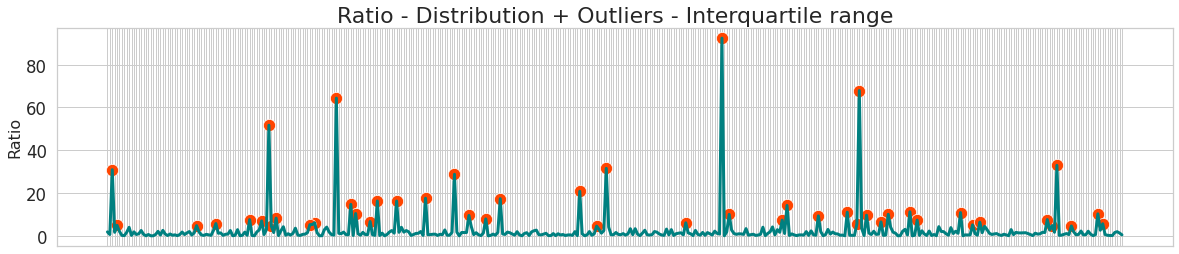

In [0]:
pd_agg_df4 = agg_df4.toPandas()

Q1 = pd_agg_df4['ratio'].quantile(0.25)
Q3 = pd_agg_df4['ratio'].quantile(0.75)
IQR = Q3 - Q1

pd_agg_df4['iqr_anomalies'] = np.where((pd_agg_df4['ratio'] < Q1-(1.5 * IQR)) | (pd_agg_df4['ratio'] > Q3+(1.5 * IQR)), 1, 0)
if (pd_agg_df4[pd_agg_df4['iqr_anomalies'] == 1].shape[0] == 0):
    print('No outliers detected')
else :
    print (str(pd_agg_df4[pd_agg_df4['iqr_anomalies'] == 1].shape[0]) + ' outliers are found')
    
    sns.set(rc={'figure.figsize':(20, 4)})
    sns.set(font_scale=1.5) 
    sns.set_style("whitegrid")
    ts = sns.lineplot(data = pd_agg_df4, x = 'nameOrig', y = 'ratio', linewidth = 3, color = 'teal')
    ax2 = sns.scatterplot(data = pd_agg_df4[pd_agg_df4['iqr_anomalies'] == 1], x = 'nameOrig', y = 'ratio', color="orangered", s=150)
    #ax2.set(xlim = ('2014-04-01', '2021-05-01'))
    plt.title('Ratio - Distribution + Outliers - Interquartile range', size = 22)
    ts.set_ylabel('Ratio', fontsize=16)
    #ts.set_xlabel('Customers', fontsize=16) 
    ts.set(xlabel=None)
    ts.set(xticklabels=[]) 

##### Percentiles

20 outliers are found

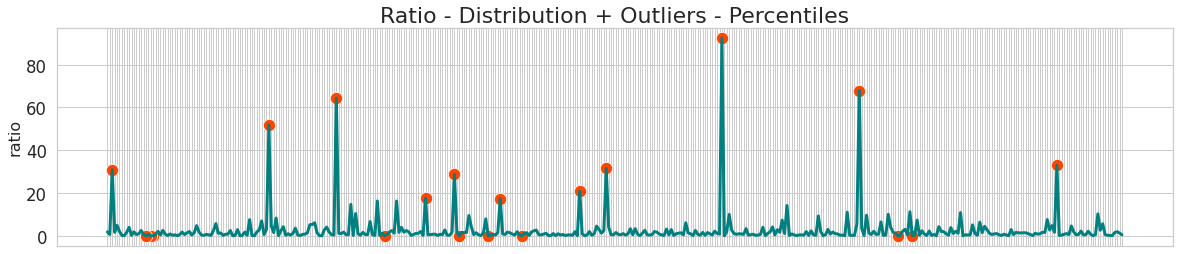

In [0]:
upper = pd_agg_df4['ratio'].quantile(0.975)
lower = pd_agg_df4['ratio'].quantile(0.025)

pd_agg_df4['perc_anomalies'] = np.where((pd_agg_df4['ratio'] < lower) | (pd_agg_df4['ratio'] > upper), 1, 0)
if (pd_agg_df4[pd_agg_df4['perc_anomalies'] == 1].shape[0] == 0):
    print('No outliers detected')
else :
    print (str(pd_agg_df4[pd_agg_df4['perc_anomalies'] == 1].shape[0]) + ' outliers are found')
    
    sns.set(rc={'figure.figsize':(20, 4)})
    sns.set(font_scale=1.5) 
    sns.set_style("whitegrid")
    ts = sns.lineplot(data = pd_agg_df4, x = 'nameOrig', y = 'ratio', linewidth = 3, color = 'teal')
    ax2 = sns.scatterplot(data = pd_agg_df4[pd_agg_df4['perc_anomalies'] == 1], x = 'nameOrig', y = 'ratio', color="orangered", s=150)
    #ax2.set(xlim = ('2014-04-01', '2021-05-01'))
    plt.title('Ratio - Distribution + Outliers - Percentiles', size = 22)
    ts.set_ylabel('ratio', fontsize=16)
    #ts.set_xlabel('customer', fontsize=16)
    ts.set(xlabel=None)
    ts.set(xticklabels=[]) 

##### Mean and STD

8 outliers are found

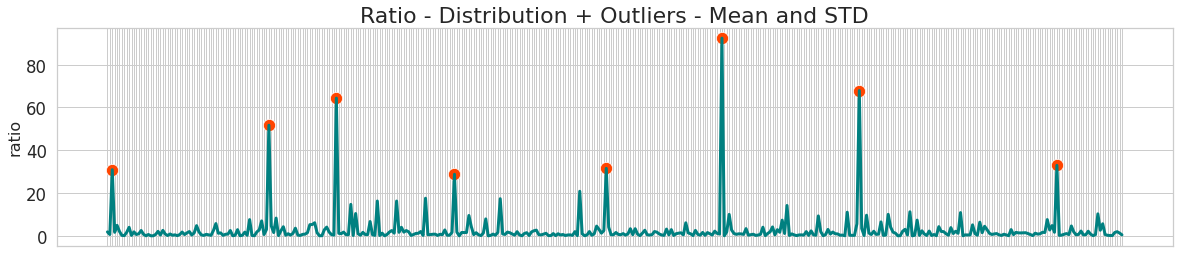

In [0]:
upper = pd_agg_df4['ratio'].mean() + 3 * pd_agg_df4['ratio'].std()
lower = pd_agg_df4['ratio'].mean() - 3 * pd_agg_df4['ratio'].std()

pd_agg_df4['std_anomalies'] = np.where((pd_agg_df4['ratio'] < lower) | (pd_agg_df4['ratio'] > upper), 1, 0)
if (pd_agg_df4[pd_agg_df4['std_anomalies'] == 1].shape[0] == 0):
    print('No outliers detected')
else :
    print (str(pd_agg_df4[pd_agg_df4['std_anomalies'] == 1].shape[0]) + ' outliers are found')
    
    sns.set(rc={'figure.figsize':(20, 4)})
    sns.set(font_scale=1.5) 
    sns.set_style("whitegrid")
    ts = sns.lineplot(data = pd_agg_df4, x = 'nameOrig', y = 'ratio', linewidth = 3, color = 'teal')
    ax2 = sns.scatterplot(data = pd_agg_df4[pd_agg_df4['std_anomalies'] == 1], x = 'nameOrig', y = 'ratio', color="orangered", s=150)
    #ax2.set(xlim = ('2014-04-01', '2021-05-01'))
    plt.title('Ratio - Distribution + Outliers - Mean and STD', size = 22)
    ts.set_ylabel('ratio', fontsize=16)
    #ts.set_xlabel('customer', fontsize=16)
    ts.set(xlabel=None)
    ts.set(xticklabels=[]) 

##### Median Absolute Deviation

20 outliers are found

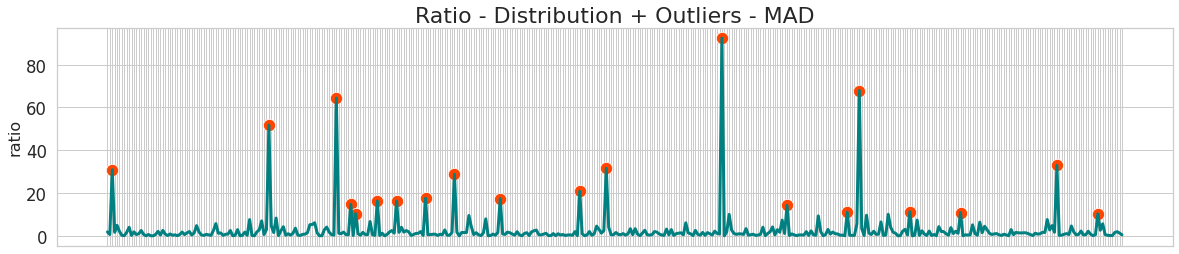

In [0]:
upper = pd_agg_df4['ratio'].median() + 3 * pd_agg_df4['ratio'].mad()
lower = pd_agg_df4['ratio'].median() - 3 * pd_agg_df4['ratio'].mad()
pd_agg_df4['mad_anomalies'] = np.where((pd_agg_df4['ratio'] < lower) | (pd_agg_df4['ratio'] > upper), 1, 0)
if (pd_agg_df4[pd_agg_df4['mad_anomalies'] == 1].shape[0] == 0):
    print('No outliers detected')
else :
    print (str(pd_agg_df4[pd_agg_df4['mad_anomalies'] == 1].shape[0]) + ' outliers are found')
    
    sns.set(rc={'figure.figsize':(20, 4)})
    sns.set(font_scale=1.5) 
    sns.set_style("whitegrid")
    ts = sns.lineplot(data = pd_agg_df4, x = 'nameOrig', y = 'ratio', linewidth = 3, color = 'teal')
    ax2 = sns.scatterplot(data = pd_agg_df4[pd_agg_df4['mad_anomalies'] == 1], x = 'nameOrig', y = 'ratio', color="orangered", s=150)
    #ax2.set(xlim = ('2014-04-01', '2021-05-01'))
    plt.title('Ratio - Distribution + Outliers - MAD', size = 22)
    ts.set_ylabel('ratio', fontsize=16)
    #ts.set_xlabel('customer', fontsize=16)
    ts.set(xlabel=None)
    ts.set(xticklabels=[]) 

#### Detect Anomalies - Model based approach

##### Clustering - Customer Level

In [0]:
#pd_agg_df4 = agg_df4.toPandas()
features_list = ['week_1', 'week_2', 'ratio']
pd_agg_df5 = pd_agg_df4[features_list]
cr = pd_agg_df5.corr().abs()
upper_tri = cr.where(np.triu(np.ones(cr.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7)]
pd_agg_df6 = pd_agg_df5.drop(axis=0,columns=to_drop)
df_grouped_scaled = StandardScaler().fit_transform(pd_agg_df6)

metrics = ['euclidean']
dist = pairwise_distances(df_grouped_scaled, metric='euclidean', n_jobs = -1)    
eps = [np.percentile(dist, 2), np.percentile(dist, 3), np.percentile(dist, 4), np.percentile(dist, 5),
      np.percentile(dist, 6), np.percentile(dist, 8), np.percentile(dist, 10),
      np.percentile(dist, 12)]
min_samples = [1, 2, 3]
silhouette_score_ = 0
for metric_ in metrics:
    for eps_ in eps:
        for min_samples_ in min_samples:
            db = DBSCAN(eps=eps_, min_samples=min_samples_, metric=metric_).fit(df_grouped_scaled)
            labels = db.labels_
            n_noise_ = list(labels).count(-1)
            if (n_noise_ > 0) :
                try :
                    if (silhouette_score(df_grouped_scaled, labels) > silhouette_score_) :
                        silhouette_score_ = silhouette_score(df_grouped_scaled, labels)
                        metrics_best = metric_
                        eps_best = eps_
                        min_samples_best = min_samples_
                except :
                    pass

db = DBSCAN(eps=eps_best, min_samples=min_samples_best, metric=metrics_best).fit(df_grouped_scaled)
labels = db.labels_
pd_agg_df4['labels_dbscan_features'] = labels

print('Best Silhouette : ' + str(np.round(silhouette_score_, 2)))
print('Best Epsilon : ' + str(np.round(eps_best, 2)))
print('Best Min samples : ' + str(np.round(min_samples_best, 0)))


pd_agg_df4['forecast_anomalies_dbscan_features'] = np.where((pd_agg_df4['labels_dbscan_features'] == -1), 1, 0)
if (pd_agg_df4[pd_agg_df4['forecast_anomalies_dbscan_features'] == 1].shape[0] == 0):
    print('No outliers detected')
else :
    print (str(pd_agg_df4[pd_agg_df4['forecast_anomalies_dbscan_features'] == 1].shape[0]) + ' outliers are found')

Best Silhouette : 0.35
Best Epsilon : 0.66
Best Min samples : 3
13 outliers are found

In [0]:
pd_agg_df4.display()

nameOrig,type,week_1,week_2,ratio,iqr_anomalies,perc_anomalies,std_anomalies,mad_anomalies,labels_dbscan_features,forecast_anomalies_dbscan_features
C646166723,CASH_OUT,502661.875,124215.8515625,0.25,0,0,0,0,0,0
C546758137,CASH_OUT,252175.15625,51241.87109375,0.2,0,0,0,0,0,0
C2101503246,CASH_OUT,91854.296875,127347.3515625,1.39,0,0,0,0,0,0
C782079880,CASH_OUT,37969.05078125,110608.34375,2.91,0,0,0,0,0,0
C1371767815,CASH_IN,53181.6015625,61631.76953125,1.16,0,0,0,0,0,0
C1294787688,CASH_OUT,609418.4375,173564.953125,0.28,0,0,0,0,0,0
C584702898,CASH_OUT,157874.078125,58734.01953125,0.37,0,0,0,0,0,0
C1345588509,CASH_OUT,33604.71875,136455.9375,4.06,0,0,0,0,0,0
C1504006441,CASH_OUT,14677.490234375,24888.220703125,1.7,0,0,0,0,0,0
C662962247,CASH_IN,281007.84375,230496.265625,0.82,0,0,0,0,0,0


# Ensemble

In [0]:
Final = pd_agg_df4

Final['AML_Score'] = Final['iqr_anomalies'] + Final['perc_anomalies'] + Final['std_anomalies'] + Final['mad_anomalies']+(5* Final['forecast_anomalies_dbscan_features']) 


Final[["nameOrig","AML_Score"]].sort_values(by=['AML_Score'], ascending=False).display()

nameOrig,AML_Score
C1953920649,9
C845806126,9
C1264826091,9
C1613170092,9
C1369412498,9
C233928716,9
C1008581294,9
C554211501,9
C1688179706,6
C1079634206,6
